- for given dataset check if a nodule is assigned to any anchor or not
- if yes check how many anchors are assigned to each nodule
- further check if this nodule is detected by the model or not.
- see for any patterns within this

In [1]:
import torch
import numpy as np
import pandas as pd
import fastcore.all as fc 

from safetensors.numpy import load_file
from voxdet.anchors import AnchorGeneratorBasedonStride
from voxdet.tfsm.voxt import RandPosCrop

In [2]:
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [3]:
sids = fc.L(pd.concat([pd.read_csv(i) for i in fc.Path("../studies/only_lidc/folds1/").glob("folds_*.csv")], axis=0)["scans"].unique().tolist())
sids

(#883) ['1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547','1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421','1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100','1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700','1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053','1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561','1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754','1.3.6.1.4.1.14519.5.2.1.6279.6001.302876782304722412779805665588','1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757','1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603'...]

In [4]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
fc.Path(sid).exists()

True

In [5]:
img = load_file(sid)
img["images"].shape, img["boxes"] #boxes are of the zyxzyx and images are of shape zyx

((283, 191, 274),
 array([[133.52631579,  59.1015625 , 194.8984375 , 163.48120301,
          92.1484375 , 235.6796875 ],
        [ 91.09022556,  24.6484375 ,  69.0390625 , 101.07518797,
          33.7890625 ,  78.8828125 ],
        [ 38.66917293, 111.8359375 , 202.6328125 ,  58.63909774,
         131.5234375 , 239.1953125 ]]))

In [6]:
rpc = RandPosCrop(crop_size=(92, 192, 192))
nimg = rpc(img)
boxes =nimg["boxes"]
boxes = torch.Tensor(boxes)
print(boxes.shape)
boxes

torch.Size([2, 6])


tensor([[ 62.5263,  59.1016, 124.8984,  92.0000,  92.1484, 165.6797],
        [ 20.0902,  24.6484,   0.0000,  30.0752,  33.7891,   8.8828]])

> we will first see how POS and NEGs are assigned in the current framework and later see how this can be done for betterment. 

In [7]:
anchors = AnchorGeneratorBasedonStride(strides=[[2, 4, 4], [4, 8, 8], [8, 16, 16], [8, 32, 32]])
anchors

AnchorGeneratorBasedonStride()

The training has the following stuff 

```python
train_cfg = dict(
    matcher=dict(
        name="set_atss_matcher", attr=dict(num_candidates=12, center_in_gt=False)
    ),
    sampler=dict(
        name="set_hard_negative_sampler",
        attr=dict(
            batch_size_per_image=500, positive_fraction=0.15, min_neg=400, pool_size=40
        ),
    ),
    reg_loss=dict(
        box_loss=dict(
            __class_fullname__="voxdet.bbox_func.reg_loss.RegLoss", iou_loss="diou", l1_loss=False, reduction="mean"
        ), # BoxDIoULoss: default; L1_BoxDIoULoss: L1+default box reg loss; L1_BoxGIoULoss: L1+BoxGIoULoss
        encode_gt=False,
        decode_pred=True,
    ),
    cls_loss="",
)
```

In [395]:
256/16

16.0

In [65]:
x = AnchorGeneratorBasedonStride(strides=[[4, 4, 4], [8, 8, 8], [16, 16, 16], [32, 32, 32]])
images = torch.zeros((1, 1, 96, 192, 192))
feature_maps = [torch.zeros((1, 6, 24, 48, 48)), torch.zeros((1, 6, 12, 24, 24)), 
                torch.zeros((1, 6, 6, 12, 12)), torch.zeros((1, 6, 3, 6, 6))]
anchors = x.forward(images, feature_maps)
print([i.shape for i in anchors])
anchors = anchors[0]
anchors.shape

[torch.Size([63180, 6])]


torch.Size([63180, 6])

In [66]:
anchors

tensor([[  0.,   0.,   0.,   4.,   4.,   4.],
        [  0.,   0.,   4.,   4.,   4.,   8.],
        [  0.,   0.,   8.,   4.,   4.,  12.],
        ...,
        [ 64., 160.,  96.,  96., 192., 128.],
        [ 64., 160., 128.,  96., 192., 160.],
        [ 64., 160., 160.,  96., 192., 192.]])

In [67]:
x.num_anchors_per_location()

[1, 1, 1, 1]

In [68]:
x.cell_anchors

[tensor([[0., 0., 0., 4., 4., 4.]]),
 tensor([[0., 0., 0., 8., 8., 8.]]),
 tensor([[ 0.,  0.,  0., 16., 16., 16.]]),
 tensor([[ 0.,  0.,  0., 32., 32., 32.]])]

In [69]:
x.strides

[[4, 4, 4], [8, 8, 8], [16, 16, 16], [32, 32, 32]]

In [70]:
x.num_anchors_per_location(), images.shape[-3:]

([1, 1, 1, 1], torch.Size([96, 192, 192]))

In [71]:
num_anchors_per_level = []
for stride in x.strides:
    print(stride)
    k = np.prod([(i/j)*k for i, j, k in zip(images.shape[-3:], stride, x.num_anchors_per_location())])
    num_anchors_per_level.append(int(k))
num_anchors_per_level, sum(num_anchors_per_level)

[4, 4, 4]
[8, 8, 8]
[16, 16, 16]
[32, 32, 32]


([55296, 6912, 864, 108], 63180)

In [72]:
def anchors_per_level(images, strides, num_anchors_per_location):
    num_anchors_per_level = []
    for stride in strides:
        k = np.prod([(i/j)*k for i, j, k in zip(images.shape[-3:], stride, num_anchors_per_location)])
        num_anchors_per_level.append(int(k))
    return num_anchors_per_level

In [73]:
from monai.data.box_utils import COMPUTE_DTYPE, box_iou, boxes_center_distance, centers_in_boxes
from monai.utils.type_conversion import convert_to_tensor

In [74]:
num_gt = boxes.shape[0]
num_anchors = anchors.shape[0]

distances_, _, anchors_center = boxes_center_distance(boxes, anchors)  # num_boxes x anchors
distances = convert_to_tensor(distances_)

In [75]:
distances.shape

torch.Size([2, 63180])

In [76]:
sum(num_anchors_per_level), num_anchors

(63180, 63180)

In [77]:
num_candidates = 12 
num_anchors_per_loc = 1 

> we have three levels for each level we have findout `num_candidates` min distance anchor boxes.
if we have N bounding boxes we will get [N, 12*3] as output

In [78]:
num_anchors_per_level

[55296, 6912, 864, 108]

In [79]:
candidate_idx_list = []
start_idx = 0
for _, apl in enumerate(num_anchors_per_level):
    end_idx = start_idx + apl * num_anchors_per_loc
    print(start_idx, end_idx)

    # topk: total number of candidates per position
    topk = min(num_candidates * num_anchors_per_loc, apl)
    # torch.topk() does not support float16 cpu, need conversion to float32 or float64
    _, idx = distances[:, start_idx:end_idx].to(torch.float32).topk(topk, dim=1, largest=False)
    # idx: shape [num_boxes x topk]
    candidate_idx_list.append(idx + start_idx)

    start_idx = end_idx
candidate_idx = torch.cat(candidate_idx_list, dim=1)
candidate_idx

0 55296
55296 62208
62208 63072
63072 63180


tensor([[15582, 15581, 15630, 13278, 15629, 13277, 13326, 17886, 15534, 13325,
         15583, 17885, 57471, 57470, 56895, 56894, 57447, 57446, 56871, 57495,
         56870, 57494, 56919, 58047, 62467, 62455, 62611, 62468, 62466, 62323,
         62599, 62456, 62454, 62311, 62479, 62612, 63099, 63135, 63100, 63105,
         63136, 63093, 63141, 63106, 63098, 63129, 63094, 63142],
        [10517, 12821, 10518, 10565, 10469, 12822, 10516,  8213, 12869, 10566,
         12773, 10470, 56762, 56763, 56786, 56186, 56787, 56187, 56210, 57338,
         56211, 56738, 57339, 56761, 62425, 62437, 62281, 62293, 62424, 62436,
         62426, 62280, 62438, 62292, 62282, 62569, 63090, 63091, 63126, 63084,
         63096, 63127, 63085, 63097, 63120, 63132, 63121, 63133]])

In [80]:
def get_candidates(distances, num_candidates, num_anchors_per_level, num_anchors_per_loc):
    candidate_idx_list = []
    start_idx = 0
    for _, apl in enumerate(num_anchors_per_level):
        end_idx = start_idx + apl * num_anchors_per_loc

        # topk: total number of candidates per position
        topk = min(num_candidates * num_anchors_per_loc, apl)
        # torch.topk() does not support float16 cpu, need conversion to float32 or float64
        _, idx = distances[:, start_idx:end_idx].to(torch.float32).topk(topk, dim=1, largest=False)
        # idx: shape [num_boxes x topk]
        candidate_idx_list.append(idx + start_idx)

        start_idx = end_idx
    candidate_idx = torch.cat(candidate_idx_list, dim=1)
    return candidate_idx

In [81]:
candidate_idx = get_candidates(distances, num_candidates, num_anchors_per_level, num_anchors_per_loc)
candidate_idx.shape

torch.Size([2, 48])

## calculate the iou between bounding boxes and anchor boxes 

In [82]:
from voxdet.bbox_func.bbox_iou import calculate_iou

In [83]:
match_quality_matrix = calculate_iou(boxes, anchors)
match_quality_matrix.shape

torch.Size([2, 63180])

In [84]:
candidate_ious = match_quality_matrix.gather(1, candidate_idx)
candidate_ious.max(1)

torch.return_types.max(
values=tensor([0.3072, 0.3932]),
indices=tensor([0, 0]))

In [85]:
candidate_ious

tensor([[0.3072, 0.1304, 0.1277, 0.0511, 0.0588, 0.0244, 0.0240, 0.0000, 0.0000,
         0.0116, 0.0000, 0.0000, 0.1066, 0.0496, 0.0203, 0.0099, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0262, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0033, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.3932, 0.0801, 0.1528, 0.0158, 0.0000, 0.0361, 0.0416, 0.0000, 0.0041,
         0.0074, 0.0000, 0.0000, 0.1214, 0.0466, 0.0060, 0.0000, 0.0025, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0227, 0.0012, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0030, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])

In [86]:
match_quality_matrix.max(1)

torch.return_types.max(
values=tensor([0.3072, 0.3932]),
indices=tensor([15582, 10517]))

In [87]:
# compute adaptive iou threshold
iou_mean_per_gt = candidate_ious.mean(dim=1)  # [num_boxes]
iou_std_per_gt = candidate_ious.std(dim=1)  # [num_boxes]
iou_thresh_per_gt = iou_mean_per_gt + iou_std_per_gt  # [num_boxes]
is_pos = candidate_ious >= iou_thresh_per_gt[:, None]  # [num_boxes x n_candidates]
is_pos

tensor([[ True,  True,  True, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False],
        [ True, False,  True, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False]])

In [88]:
def is_pos_bbox(boxes, anchors, candidate_idx):
    match_quality_matrix = calculate_iou(boxes, anchors)
    candidate_ious = match_quality_matrix.gather(1, candidate_idx)
    iou_mean_per_gt = candidate_ious.mean(dim=1)  # [num_boxes]
    iou_std_per_gt = candidate_ious.std(dim=1)  # [num_boxes]
    iou_thresh_per_gt = iou_mean_per_gt + iou_std_per_gt  # [num_boxes]
    is_pos = candidate_ious >= iou_thresh_per_gt[:, None]  # [num_boxes x n_candidates]
    return is_pos, match_quality_matrix

In [89]:
is_pos.sum(axis=1)

tensor([4, 3])

In [90]:
candidate_idx[0][is_pos[0]]

tensor([15582, 15581, 15630, 57471])

> in_case if the same anchor is assigned to two bounding boxes. we have to make sure that box with max iou is assigned to that box

In [91]:
for ng in range(num_gt):
    candidate_idx[ng, :] += ng * num_anchors
candidate_idx

tensor([[ 15582,  15581,  15630,  13278,  15629,  13277,  13326,  17886,  15534,
          13325,  15583,  17885,  57471,  57470,  56895,  56894,  57447,  57446,
          56871,  57495,  56870,  57494,  56919,  58047,  62467,  62455,  62611,
          62468,  62466,  62323,  62599,  62456,  62454,  62311,  62479,  62612,
          63099,  63135,  63100,  63105,  63136,  63093,  63141,  63106,  63098,
          63129,  63094,  63142],
        [ 73697,  76001,  73698,  73745,  73649,  76002,  73696,  71393,  76049,
          73746,  75953,  73650, 119942, 119943, 119966, 119366, 119967, 119367,
         119390, 120518, 119391, 119918, 120519, 119941, 125605, 125617, 125461,
         125473, 125604, 125616, 125606, 125460, 125618, 125472, 125462, 125749,
         126270, 126271, 126306, 126264, 126276, 126307, 126265, 126277, 126300,
         126312, 126301, 126313]])

In [92]:
ious_inf = torch.full_like(match_quality_matrix, -float("inf")).view(-1)
ious_inf.shape

torch.Size([126360])

In [93]:
index = candidate_idx.view(-1)[is_pos.view(-1)]
index

tensor([ 15582,  15581,  15630,  57471,  73697,  73698, 119942])

In [94]:
ious_inf[index] = match_quality_matrix.view(-1)[index]
ious_inf

tensor([-inf, -inf, -inf,  ..., -inf, -inf, -inf])

In [95]:
ious_inf = ious_inf.view_as(match_quality_matrix)
ious_inf.shape

torch.Size([2, 63180])

In [96]:
matched_vals, matches = ious_inf.to(torch.float32).max(dim=0)

In [97]:
matches[matched_vals == -float("inf")] = -1

In [98]:
matches.unique(return_counts=True)

(tensor([-1,  0,  1]), tensor([63173,     4,     3]))

In [99]:
matched_vals[matches==1], matched_vals[matches==0]

(tensor([0.3932, 0.1528, 0.1214]), tensor([0.1304, 0.3072, 0.1277, 0.1066]))

In [43]:
matched_vals.unique()

tensor([  -inf, 0.0981, 0.1292, 0.1611, 0.2386, 0.2748, 0.2829, 0.3457])

In [44]:
def assign_bbox_2_anchors(candidate_idx, match_quality_matrix,  is_pos, num_anchors):
    num_gt = is_pos.shape[0]
    for ng in range(num_gt):
        candidate_idx[ng, :] += ng * num_anchors    
    ious_inf = torch.full_like(match_quality_matrix, -float("inf")).view(-1)
    index = candidate_idx.view(-1)[is_pos.view(-1)]
    ious_inf[index] = match_quality_matrix.view(-1)[index]
    ious_inf = ious_inf.view_as(match_quality_matrix)
    matched_vals, matches = ious_inf.to(torch.float32).max(dim=0)
    matches[matched_vals == -float("inf")] = -1
    return matches

## Combine everything
- For each image
- There are N bounding box
- For each bbox find out how many pos boxes are present. for these findout iou for each
- for each level check how many anchors are selected.

In [45]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
img = load_file(sid)
rpc = RandPosCrop(crop_size=(92, 192, 192))
nimg = rpc(img)
boxes =nimg["boxes"]
boxes = torch.Tensor(boxes)
boxes.shape, nimg["images"].shape

(torch.Size([2, 6]), (92, 192, 192))

In [46]:
num_candidates = 12 
num_anchors_per_loc = 1 

In [47]:
num_anchors_per_level = anchors_per_level(images, x.strides, x.num_anchors_per_location())
num_anchors_per_level

[110592, 13824, 1728, 216]

In [48]:
num_gt = boxes.shape[0]
num_anchors = anchors.shape[0]

distances_, _, anchors_center = boxes_center_distance(boxes, anchors)  # num_boxes x anchors
distances = convert_to_tensor(distances_)
distances.shape

torch.Size([2, 126360])

In [49]:
candidate_idx = get_candidates(distances, num_candidates, num_anchors_per_level, num_anchors_per_loc)
candidate_idx

tensor([[ 29406,  31710,  27102,  29405,  29454,  31709,  31758,  27101,  34014,
          27150,  29453,  31757, 114495, 113919, 114494, 115071, 113918, 115070,
         114471, 113343, 113895, 114470, 113342, 115047, 124963, 124819, 124951,
         125107, 124807, 124675, 125095, 124964, 124820, 124663, 124962, 124818,
         126207, 126243, 126171, 126208, 126244, 126172, 126213, 126279, 126249,
         126177, 126201, 126214],
        [ 22037,  19733,  24341,  22038,  19734,  22085,  24342,  17429,  26645,
          21989,  19781,  24389, 113210, 113786, 113211, 112634, 113234, 113787,
         113810, 112635, 114362, 113235, 112658, 113811, 124777, 124633, 124789,
         124921, 124645, 124933, 124776, 124489, 124632, 124788, 124501, 125065,
         126198, 126162, 126234, 126199, 126163, 126192, 126156, 126235, 126204,
         126168, 126228, 126270]])

In [50]:
is_pos, match_quality_matrix = is_pos_bbox(boxes, anchors, candidate_idx)
is_pos, match_quality_matrix.shape

(tensor([[ True,  True, False,  True,  True, False, False, False, False, False,
          False, False,  True, False,  True, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False,
          False, False,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False]]),
 torch.Size([2, 126360]))

In [51]:
matches = assign_bbox_2_anchors(candidate_idx, match_quality_matrix, is_pos, num_anchors)
matches.shape

torch.Size([126360])

In [52]:
for gt in range(boxes.shape[0]):
    print(match_quality_matrix[gt][matches==gt])

tensor([0.0855, 0.1913, 0.0839, 0.1473, 0.0877, 0.1965])
tensor([0.1274, 0.3131, 0.1261, 0.1017, 0.1732])


In [53]:
anchor_idx = torch.where(matches == 0)[0]
anchor_idx

tensor([ 29405,  29406,  29454,  31710, 114494, 114495])

In [54]:
anchors_cumsum = torch.Tensor([0]+num_anchors_per_level).cumsum(axis=0)
anchors_cumsum

tensor([     0., 110592., 124416., 126144., 126360.])

In [55]:
#anchor_bins = torch.Tensor([[0, 110592], [110592, 124416], [124416, 126144]]).long()
#anchor_bins = torch.Tensor([[0, 196608], [196608, 221184], [221184, 224256]]).long()
anchor_bins = torch.Tensor([[0, 110592], [110592, 124416], [124416, 126144], [126144, 126360]]).long()
anchor_bins

tensor([[     0, 110592],
        [110592, 124416],
        [124416, 126144],
        [126144, 126360]])

In [56]:
tx = (anchor_idx[None]>anchor_bins[:, 0][..., None]) & (anchor_idx[None] <= anchor_bins[:, 1][..., None])
tx

tensor([[ True,  True,  True,  True, False, False],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])

In [57]:
rowidx, colidx = torch.where(tx==1)
rowidx, colidx

(tensor([0, 0, 0, 0, 1, 1]), tensor([0, 1, 2, 3, 4, 5]))

In [58]:
assert  all(colidx == torch.arange(colidx.shape[0]))

In [59]:
def find_anchors_level(anchor_idx, anchor_bins):
    tx = (anchor_idx[None]>anchor_bins[:, 0][..., None]) & (anchor_idx[None] <= anchor_bins[:, 1][..., None])
    rowidx, colidx = torch.where(tx==1)
    assert  all(colidx == torch.arange(colidx.shape[0]))
    return rowidx

- total anchors assigned to each level [x]
- per gt how many pos are present [x]
- per gt what are the pos iou scores we are getting [x]
- per crop how many gts are present 

In [60]:
from tqdm import tqdm

In [481]:
level = torch.zeros(4)
total_gt_boxes = []
iou_scores = []
max_iou_scores = []
num_anchors = anchors.shape[0]
box2level = []
nogt=0
for sid in tqdm(sids):
    sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
    if not fc.Path(sid).exists(): continue
    img = load_file(sid)
    for _ in range(4):
        nimg = rpc(img)
        boxes =nimg["boxes"]
        boxes = torch.Tensor(boxes)
        num_gt = boxes.shape[0]
        distances_, _, anchors_center = boxes_center_distance(boxes, anchors)  # num_boxes x anchors
        distances = convert_to_tensor(distances_)
        candidate_idx = get_candidates(distances, num_candidates, num_anchors_per_level, num_anchors_per_loc)
        is_pos, match_quality_matrix = is_pos_bbox(boxes, anchors, candidate_idx)
        matches = assign_bbox_2_anchors(candidate_idx, match_quality_matrix, is_pos, num_anchors)
        total_gt_boxes.append(match_quality_matrix.shape[0])
        for gt in range(match_quality_matrix.shape[0]):
            anchor_idx = torch.where(matches == gt)[0]
            rowidx = find_anchors_level(anchor_idx, anchor_bins)
            for row in rowidx: level[row]+=1
            box2level.append(rowidx.unique())
            iou_scores.append(match_quality_matrix[gt][matches==gt])
            
            if match_quality_matrix[gt][matches==gt].shape[0]>0:
                max_iou_scores.append(match_quality_matrix[gt][matches==gt].max())
            else:
                #nodules with not even one gt
                nogt+=1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [05:01<00:00,  2.92it/s]


In [482]:
np.mean(total_gt_boxes), np.median(total_gt_boxes)

(1.7712585034013606, 1.0)

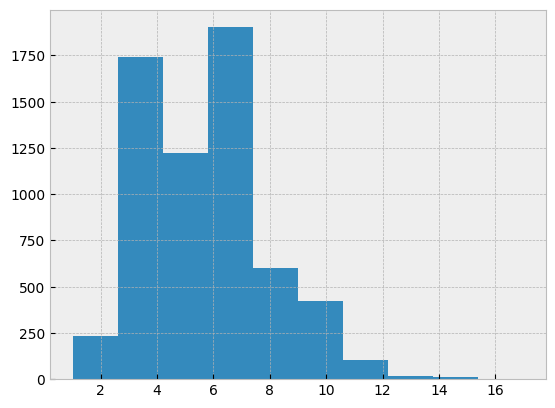

In [483]:
# pos anchors per box
plt.hist([i.shape[0] for i in iou_scores])
plt.show()

In [496]:
np.mean([i.shape[0] for i in iou_scores])

5.6277804448711795

In [485]:
anchor_idx

tensor([ 15891,  15892,  15940,  18195,  18196,  18244, 112826])

In [486]:
rowidx

tensor([0, 0, 0, 0, 0, 0, 1])

In [487]:
sum(total_gt_boxes)

6249

In [488]:
level

tensor([13180., 13502.,  6333.,  2153.])

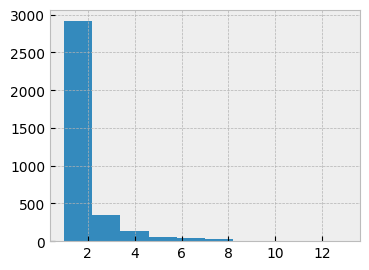

In [489]:
fig, ax = plt.subplots(figsize=(4, 3), nrows=1, ncols=1)
ax.hist(total_gt_boxes)
plt.show()

In [490]:
torch.stack(max_iou_scores)

tensor([0.2680, 0.3224, 0.3078,  ..., 0.1890, 0.1795, 0.1039])

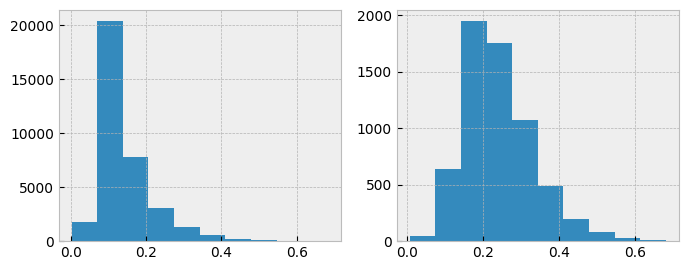

In [491]:
iou = torch.cat(iou_scores).numpy()
max_iou = torch.stack(max_iou_scores).numpy()
fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=2)
ax.flat[0].hist(iou)
ax.flat[1].hist(max_iou)
plt.show()

In [492]:
np.median(iou), np.mean(iou), np.median(max_iou), np.mean(max_iou)

(0.11858764, 0.14056174, 0.22688995, 0.24089015)

In [493]:
max_iou[max_iou<0.2].shape[0]/max_iou.shape[0]

0.37926068170907346

In [494]:
## How many boxes have only zero as +ve boxes

In [501]:
for t in range(4):
    print(torch.stack([(i==t).sum()/len(i) for i in  box2level]).unique(return_counts=True))

(tensor([0.0000, 0.3333, 0.5000, 1.0000]), tensor([2887,  556, 2646,  160]))
(tensor([0.0000, 0.3333, 0.5000, 1.0000]), tensor([1157,  741, 4191,  160]))
(tensor([0.0000, 0.3333, 0.5000, 1.0000]), tensor([3148,  741, 2288,   72]))
(tensor([0.0000, 0.3333, 0.5000, 1.0000]), tensor([5140,  185,  741,  183]))


In [502]:
box2level

[tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1, 2]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([1]),
 tensor([3]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([2, 3]),
 tensor([3]),
 tensor([1, 2]),
 tensor([2, 3]),
 tensor([2, 3]),
 tensor([0, 1]),
 tensor([2, 3]),
 tensor([0, 1]),
 tensor([2, 3]),
 tensor([0, 1]),
 tensor([2, 3]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1, 2]),
 tensor([0, 1]),
 tensor([0, 1, 2]),
 tensor([0]),
 tensor([0, 1, 2]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([1, 2]),
 tensor([2, 3]),
 tensor([0, 1, 2]),
 tensor([1]),
 tensor([3]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1, 2]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([0, 1]),
 tensor([2, 3]),
 tensor([1, 2, 3]),
 tensor([2, 3]),
 tensor([1, 2]),
 tensor([2, 3]

## Open questions 
- Should we increase the image size?
- Should we add an extra layer of FPN?
- How to improve the positive box iou?
    
 
## Image size = 96, 192, 192
- 96, 192, 192 = <20% iou is 42% data.
- even though we have setup num candidates as 12. on average this is only 1.71.
- 313 times small bounding boxes are also identified.
- mean and median of the iou are 0.14 and 0.12 respectively. 
- for max iou it is 0.22 and 0.21 respectively.


## Image size = 96, 256, 256
- improved to 2.09
- not much improvements in anything else. only 0 level we have 382 nodules 


## Some conclusions
- good to have 